In [1]:
import os
from sys import getsizeof

import numpy as np
import pandas as pd
import stft
import scipy
from scipy import signal
from scipy.io import wavfile
from scipy.sparse import csc_matrix, csr_matrix
import matplotlib.pyplot as plt

In [2]:
from chord_rec_lib import dnames, format_name
load_dnames_once_f = True

In [3]:
HEAD_DIR = '..'
if load_dnames_once_f:
    for d in dnames:
        dnames[d] = os.path.join(HEAD_DIR, dnames[d])
    load_dnames_once_f = False

# Checking algorithm for one song

In [4]:
fname = os.listdir(os.path.join(dnames['WAV_SONGS_DIR']))[0]
fname

'song_789.wav'

Following values set in honour of A.Cogliati papers

In [5]:
flength = 2048
wind = signal.hamming
hopsize = 128

stft.spectrogram(data, framelength=1024, hopsize=None, overlap=None, centered=True, window=None, halved=True, transform=None, padding=0, save_settings=True)

spectrogramm.shape == bins x frames

In [6]:
sample_rate, samples = wavfile.read(os.path.join(dnames['WAV_SONGS_DIR'], fname))
spectrogramm = stft.spectrogram(samples, framelength=flength, hopsize=hopsize, window=wind)
spectrogramm = scipy.absolute(spectrogramm)
spectrogramm.shape

(1025, 41537)

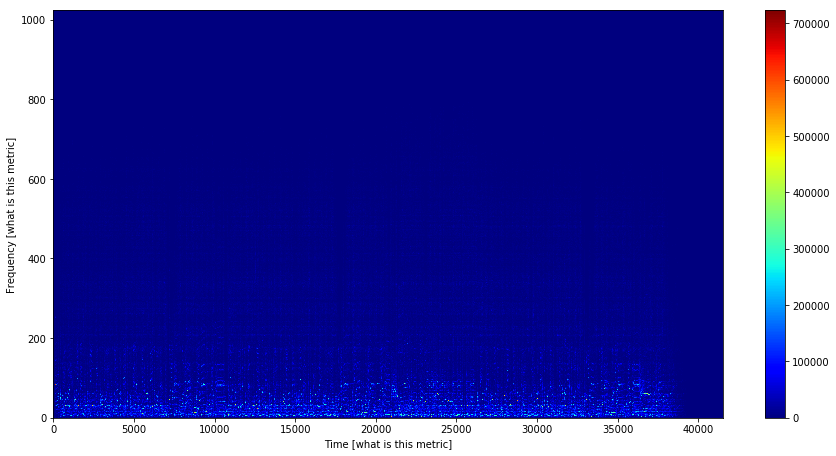

In [7]:
plt.figure(figsize=(15, 7.5))
plt.imshow(spectrogramm, origin="lower", cmap="jet",aspect="auto", interpolation="nearest")
plt.colorbar()
plt.ylabel('Frequency [what is this metric]')
plt.xlabel('Time [what is this metric]')
plt.show()

There are so much point with almost null value

In [8]:
xaxis = np.logspace(-2, np.log10(spectrogramm.size), 200)
yaxis_counts = np.array([(spectrogramm<x).sum() for x in xaxis])
yaxis_sums = np.array([spectrogramm[spectrogramm<x].sum() for x in xaxis])

In [9]:
thold10 = xaxis[np.argmax(yaxis_sums/spectrogramm.sum()>=0.1)]
thold20 = xaxis[np.argmax(yaxis_sums/spectrogramm.sum()>=0.2)]

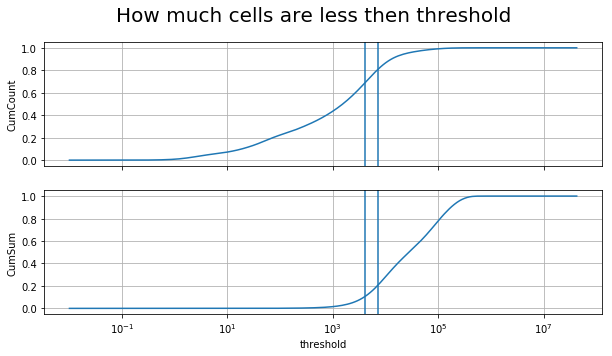

In [10]:
plt.figure(figsize=(10,5))
plt.suptitle('How much cells are less then threshold', fontsize=20)

ax1 = plt.subplot(211)
plt.plot(xaxis, yaxis_counts/spectrogramm.size)
plt.ylabel('CumCount')
plt.grid()
plt.xticks(visible=False)
plt.axvline(thold10)
plt.axvline(thold20)

ax2 = plt.subplot(212, sharex=ax1)
plt.plot(xaxis, yaxis_sums/spectrogramm.sum())
plt.grid()
plt.xlabel('threshold')
plt.ylabel('CumSum')
plt.xscale('log')
plt.axvline(thold10)
plt.axvline(thold20)

plt.show()

In [11]:
sparse = spectrogramm.copy()
sparse[sparse<thold20]=0
sparse = csc_matrix(sparse)

In [12]:
print('full  : memorysize={} sum={:.2f} perc={:.2%}'.format(getsizeof(spectrogramm), spectrogramm.sum(), 1))
print('sparce: memorysize={} sum={:.2f} perc={:.2%}'.format(getsizeof(sparse), sparse.sum(), sparse.sum()/spectrogramm.sum()))

full  : memorysize=136 sum=275479143111.10 perc=100.00%
sparce: memorysize=56 sum=218658401783.84 perc=79.37%


In [13]:
sparse

<1025x41537 sparse matrix of type '<class 'numpy.float64'>'
	with 8175626 stored elements in Compressed Sparse Column format>

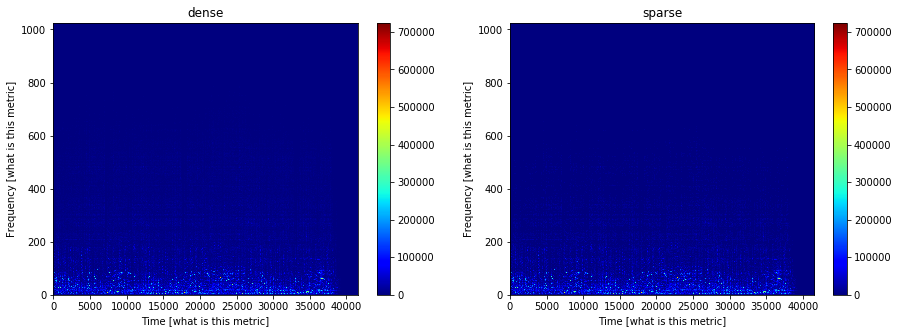

In [14]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.imshow(spectrogramm, origin="lower", cmap="jet",aspect="auto", interpolation="nearest")
plt.colorbar()
plt.title('dense')
plt.ylabel('Frequency [what is this metric]')
plt.xlabel('Time [what is this metric]')

plt.subplot(122)
plt.imshow(sparse.todense(), origin="lower", cmap="jet",aspect="auto", interpolation="nearest")
plt.colorbar()
plt.title('sparse')
plt.ylabel('Frequency [what is this metric]')
plt.xlabel('Time [what is this metric]')
plt.show()

In [15]:
scipy.sparse.save_npz(os.path.join(dnames['SPECTRS_DIR'], fname.replace('.wav','')),sparse)